# Detecting Midjourney Images via Feature Engineering & Classification

**Objectives**

- **Engineer Discriminative Features**
    Develop and extract features that effectively separate Stable Diffusion (AI-generated) images from authentic camera-captured photos using frequency, color, and texture analysis

- **Build Reproducible Pipeline**

    Construct a robust feature extraction pipeline that generates a tabular dataset suitable for ML. Ensure consistency and reproducibility across experiments.

- **Train & Evaluate Classifiers**

    Implement a classifier architectures such as Random Forest, XGBoost, SVM or Neural Networks. Rigorously evaluate performance using industry-standard metrics and confusion matrices

- **Quantify Feature Relevance**

    Apply multiple interpretability techniques such as Gini importance. Permutation importance, and SHAP values to understand which features drive classification decisions.


**Dataset Structure**
```bash
imagenet_midjourney/
|----test/ 
| |----ai/ 
| | |--[AI-generated images] (Stable Diffusion/Midjourney) 
| | Label: 1 (fake) 
| |----nature/ 
| | |--[Natural camera images] 
| | (Non-AI photographs) 
| | Label: 0 (real)
```

## Imports

In [29]:
import os
import cv2
import numpy as np
import pandas as pd

from skimage import io, color, img_as_ubyte
from tqdm import tqdm

from scipy.stats import linregress, gmean, pearsonr, kurtosis

from skimage.feature import graycomatrix, graycoprops

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

DATASET_DIR = "imagenet_midjourney/test"

CATEGORIES = {
    "ai": 1,
    "nature": 0
}

IMG_SIZE = (1024, 1024)
COLOR_MODE = 'rgb'

## Image Loading & Preprocessing

Load images from dataset directories, normalize formats, and prepare for feature extraction. Handle various input formats consistently.

In [15]:
def load_and_preprocess_images(base_dir, categories, img_size=(1024, 1024), color_mode='rgb'):
    X, y, paths = [], [], []

    for category, label in categories.items():
        folder = os.path.join(base_dir, category)
        if not os.path.exists(folder):
            print(f"Folder not encountered: {folder}")
            continue

        for filename in tqdm(os.listdir(folder), desc=f"Loading {category}"):
            file_path = os.path.join(folder, filename)

            if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.webp')):
                continue

            try:
                image = io.imread(file_path)

                if color_mode == 'rgb':
                    if image.ndim == 2:
                        image = color.gray2rgb(image)
                    elif image.shape[2] == 4:
                        image = color.rgba2rgb(image)
                elif color_mode == 'gray':
                    image = color.rgb2gray(image)

                image = cv2.resize(img_as_ubyte(image), img_size)

                image = image.astype(np.float32) / 255.0

                X.append(image)
                y.append(label)
                paths.append(file_path)
                
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

    X = np.array(X)
    y = np.array(y)
    return X, y, paths

In [16]:
X, y, image_paths = load_and_preprocess_images(DATASET_DIR, CATEGORIES, IMG_SIZE, COLOR_MODE)

print(f"Total imágenes cargadas: {len(X)}")
print(f"Dimensión de ejemplo: {X[0].shape}")

Loading nature: 100%|██████████| 500/500 [00:08<00:00, 58.67it/s]


Total imágenes cargadas: 1000
Dimensión de ejemplo: (1024, 1024, 3)


## Feature Computation

Extract per-image features across frequency, color, and texture domains. Generate comprehensive feature vectors for each sample.

### Feature Family I: Frequency & Spectrum Analysis (FFT)

In [17]:
def compute_fft_features(image):
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray = gray.astype(np.float32) / 255.0

    fft2 = np.fft.fft2(gray)
    fshift = np.fft.fftshift(fft2)
    magnitude_spectrum = np.abs(fshift) ** 2

    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    radius = np.sqrt((x - ccol) ** 2 + (y - crow) ** 2).astype(np.int32)

    radial_profile = np.bincount(radius.ravel(), magnitude_spectrum.ravel()) / np.bincount(radius.ravel())
    radial_profile = radial_profile[1:]

    radial_power_spectrum_mean = np.mean(radial_profile)

    freqs = np.arange(1, len(radial_profile) + 1)
    log_freqs = np.log(freqs)
    log_power = np.log(radial_profile + 1e-8)
    slope, intercept, _, _, _ = linregress(log_freqs, log_power)
    spectral_slope = slope

    spectral_flatness = gmean(radial_profile + 1e-8) / (np.mean(radial_profile) + 1e-8)

    cutoff = len(radial_profile) // 3
    high_freq_energy = np.sum(radial_profile[-cutoff:])
    total_energy = np.sum(radial_profile)
    high_freq_ratio = high_freq_energy / (total_energy + 1e-8)

    return {
        'radial_power_spectrum_mean': radial_power_spectrum_mean,
        'spectral_slope': spectral_slope,
        'spectral_flatness': spectral_flatness,
        'high_freq_ratio': high_freq_ratio
    }


### Feature Family II: Colo & Chrominance Analysis

In [18]:
def safe_pearsonr(a, b):
    if np.std(a) < 1e-8 or np.std(b) < 1e-8:
        return 0.0
    r, _ = pearsonr(a, b)
    return np.nan_to_num(r, nan=0.0, posinf=0.0, neginf=0.0)

def safe_kurtosis(x):
    if x.size == 0 or np.allclose(x, x.flat[0], atol=1e-8) or np.std(x) < 1e-8:
        return 0.0
    val = kurtosis(x, fisher=False)
    return np.nan_to_num(val, nan=0.0, posinf=0.0, neginf=0.0)

def compute_color_features(image):
    img_8bit = (image * 255).astype(np.uint8)

    R = img_8bit[:, :, 0].astype(np.float32).ravel()
    G = img_8bit[:, :, 1].astype(np.float32).ravel()
    B = img_8bit[:, :, 2].astype(np.float32).ravel()

    corr_rg = safe_pearsonr(R, G)
    corr_rb = safe_pearsonr(R, B)
    corr_gb = safe_pearsonr(G, B)
    
    rgb_corr_mean = np.mean([corr_rg, corr_rb, corr_gb])
    rgb_corr_std = np.std([corr_rg, corr_rb, corr_gb])

    ycbcr = cv2.cvtColor(img_8bit, cv2.COLOR_RGB2YCrCb)
    Y, Cr, Cb = cv2.split(ycbcr)  
    
    cb_kurt = safe_kurtosis(Cb.ravel())
    cr_kurt = safe_kurtosis(Cr.ravel())

    cb_lap = cv2.Laplacian(Cb.astype(np.float32), cv2.CV_32F, ksize=3)
    cr_lap = cv2.Laplacian(Cr.astype(np.float32), cv2.CV_32F, ksize=3)

    cb_lap = np.clip(cb_lap, -5000, 5000)
    cr_lap = np.clip(cr_lap, -5000, 5000)

    cb_residual_kurt = safe_kurtosis(cb_lap.ravel())
    cr_residual_kurt = safe_kurtosis(cr_lap.ravel())

    return {
        'rgb_corr_mean': rgb_corr_mean,
        'rgb_corr_std': rgb_corr_std,
        'cb_kurtosis': cb_kurt,
        'cr_kurtosis': cr_kurt,
        'cb_residual_kurtosis': cb_residual_kurt,
        'cr_residual_kurtosis': cr_residual_kurt
    }

### Feature Family III: 

In [19]:
def compute_glcm_features(image, levels=64, distances=[1, 2, 4], angles=None):

    if angles is None:
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    gray_q = np.floor(gray / (256 / levels)).astype(np.uint8)

    glcm = graycomatrix(
        gray_q,
        distances=distances,
        angles=angles,
        levels=levels,
        symmetric=True,
        normed=True
    )

    props = {}
    for prop in ['contrast', 'homogeneity', 'energy', 'correlation']:
        vals = graycoprops(glcm, prop)
        props[prop] = np.mean(vals)

    for k in props:
        if np.isnan(props[k]) or np.isinf(props[k]):
            props[k] = 0.0

    return props

## Tabular Dataset Creation

In [20]:
fft_feature_list = []
color_features_list = []
glcm_feature_list = []

for img in tqdm(X, desc="Extracting features"):
    fft = compute_fft_features(img)
    color = compute_color_features(img)
    texture = compute_glcm_features(img)

    fft_feature_list.append(list(fft.values()))
    color_features_list.append(list(color.values()))
    glcm_feature_list.append(list(texture.values()))

fft_features = np.array(fft_feature_list)
color_features = np.array(color_features_list)
texture_features = np.array(glcm_feature_list)

fft_features = np.nan_to_num(fft_features, nan=0.0, posinf=0.0, neginf=0.0)
color_features = np.nan_to_num(color_features, nan=0.0, posinf=0.0, neginf=0.0)
texture_features = np.nan_to_num(texture_features, nan=0.0, posinf=0.0, neginf=0.0)

print(f"FFT features shape: {fft_features.shape}")
print(f"Color features shape: {color_features.shape}")
print(f"GLCM features shape: {texture_features.shape}")
print("NaN restantes:", np.isnan(texture_features).sum())

Extracting features: 100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]

FFT features shape: (1000, 4)
Color features shape: (1000, 6)
GLCM features shape: (1000, 4)
NaN restantes: 0


In [21]:
X_features = np.concatenate([fft_features, color_features, texture_features], axis=1)

print(f"Feature matrix shape: {X_features.shape}")

Feature matrix shape: (1000, 14)


In [22]:
fft_cols = list(fft.keys())
color_cols = list(color.keys())
texture_cols = list(texture.keys())

columns = fft_cols + color_cols + texture_cols

df_features = pd.DataFrame(X_features, columns=columns)
df_features['label'] = y

df_features.to_csv("image_features_dataset.csv", index=False)
print("✅ Dataset tabular creado y guardado en 'image_features_dataset.csv'")
print(df_features.head())

✅ Dataset tabular creado y guardado en 'image_features_dataset.csv'
   radial_power_spectrum_mean  spectral_slope  spectral_flatness  \
0                4.072967e+06       -3.685701           0.000191   
1                4.598615e+06       -2.746608           0.000935   
2                2.854014e+06       -2.980498           0.000276   
3                6.183829e+06       -3.912426           0.000067   
4                2.960350e+06       -4.061807           0.000042   

   high_freq_ratio  rgb_corr_mean  rgb_corr_std  cb_kurtosis  cr_kurtosis  \
0         0.000003       0.980740      0.011644     5.467102     3.611281   
1         0.000041       0.960358      0.023327     3.273891     3.265245   
2         0.000010       0.934752      0.040740     7.163840     5.574917   
3         0.000001       0.733996      0.178570     3.526943     3.415970   
4         0.000002       0.805398      0.011754     3.413666     2.298576   

   cb_residual_kurtosis  cr_residual_kurtosis   contrast  ho

## Train/Test Splitting

Apply stratified splitting or cross-validation to maintain class balance and enable robust evaluation.

In [23]:
X = df_features.drop("label", axis=1).values
y = df_features["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Class distribution (train): {np.bincount(y_train)}")
print(f"Class distribution (test): {np.bincount(y_test)}")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nCross-validation setup:")
print(cv)

Train samples: 800
Test samples: 200
Class distribution (train): [400 400]
Class distribution (test): [100 100]

Cross-validation setup:
StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


## Classifier Training

Train Random Forest, XGBoost, and SVM-RBF models. Perform Hyperparameter tuning for optimal performance.

### Random Forest

In [24]:
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

print("✅ Best Random Forest params:", rf_grid.best_params_)
print("RF CV F1 Score:", rf_grid.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
✅ Best Random Forest params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 500}
RF CV F1 Score: 0.9411953674731446


### XGBoost

In [25]:
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400, 600],
    'max_depth': [3, 5, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_

print("✅ Best XGBoost params:", xgb_grid.best_params_)
print("XGBoost CV Accuracy:", xgb_grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\polpu\Desktop\GitHub Repositories\detect-AI-midjourney-images\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:49:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Best XGBoost params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 600, 'subsample': 0.8}
XGBoost CV Accuracy: 0.9574999999999999


In [26]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

svm_param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 0.1, 0.01, 0.001]
}

svm_grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train, y_train)
svm_best = svm_grid.best_estimator_

print("✅ Best SVM params:", svm_grid.best_params_)
print("SVM CV Accuracy:", svm_grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ Best SVM params: {'svm__C': 10, 'svm__gamma': 0.01}
SVM CV Accuracy: 0.9512499999999999


In [ ]:
models = {
    "RandomForest": rf_best,
    "XGBoost": xgb_best,
    "SVM-RBF": svm_best
}

print("\n=== TEST SET PERFORMANCE ===")
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))


=== TEST SET PERFORMANCE ===

RandomForest Accuracy: 0.9550
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       100
           1       0.95      0.96      0.96       100

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200


XGBoost Accuracy: 0.9550
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       100
           1       0.96      0.95      0.95       100

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200


SVM-RBF Accuracy: 0.9450
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       100
           1       0.96      0.93      0.94       100

    accuracy                           0.94       200
   macro avg   

## Evaluation & Interpretation


=== RandomForest ===
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       100
           1       0.95      0.96      0.96       100

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200



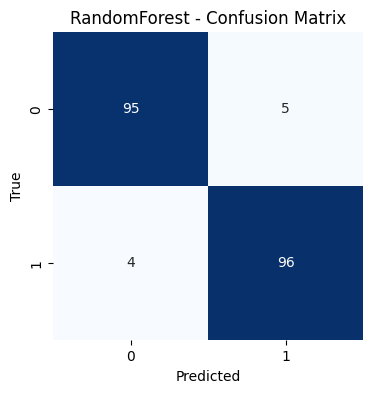


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       100
           1       0.96      0.95      0.95       100

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200



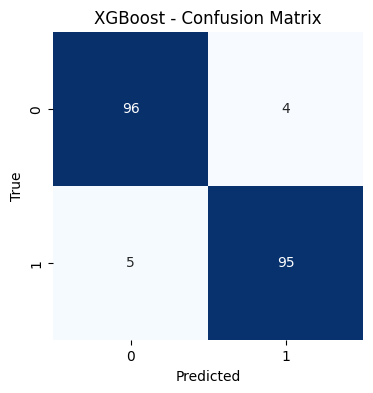


=== SVM-RBF ===
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       100
           1       0.96      0.93      0.94       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200



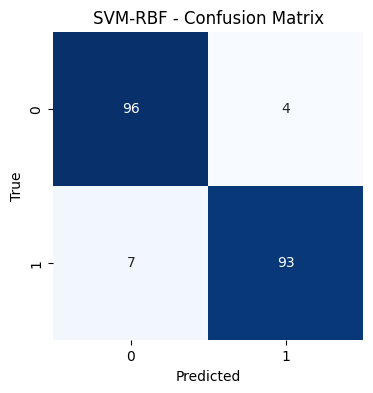


📊 Summary of model performance:


,Model,Accuracy,Precision,Recall,F1
0,RandomForest,0.955,0.950495,0.96,0.955224
1,XGBoost,0.955,0.959596,0.95,0.954774
2,SVM-RBF,0.945,0.958763,0.93,0.944162


In [ ]:
results = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

metrics_df = pd.DataFrame(results)
print("\n📊 Summary of model performance:")
display(metrics_df)

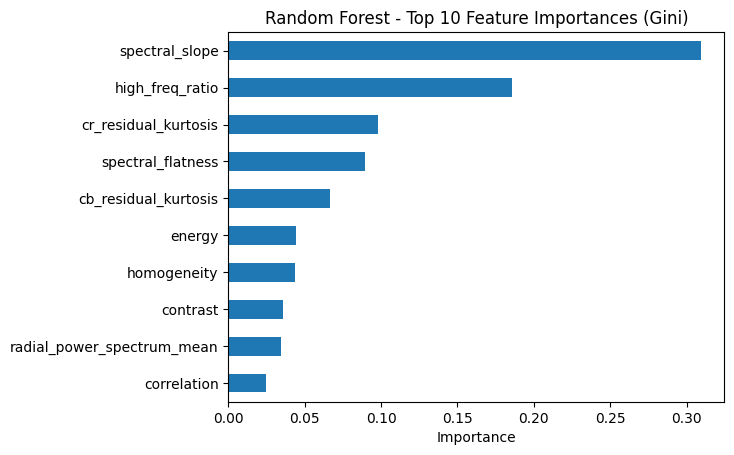

ValueError: could not convert string to float: '[5E-1]'

In [30]:
feature_names = df_features.drop(columns=['label']).columns

rf_importances = pd.Series(rf_best.feature_importances_, index=feature_names)
rf_importances.sort_values(ascending=False).head(10).plot.barh()
plt.title("Random Forest - Top 10 Feature Importances (Gini)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)